# Notebook 4 : Model Training and Evaluation

## Configuration de l'environnement

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Sklearn models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Boosting libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# TensorFlow/Keras for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from scikeras.wrappers import KerasRegressor

print("All libraries imported successfully!")

All libraries imported successfully!


## Parameters

In [2]:
# Set random seed for reproducibility
R_seed = 42
np.random.seed(R_seed)

# K-Fold Cross-Validation setup
N_FOLDS = 5
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=R_seed)

print(f"Random seed: {R_seed}")
print(f"Cross-validation: {N_FOLDS}-Fold")

Random seed: 42
Cross-validation: 5-Fold


## Load Preprocessed Datasets

In [3]:
# Load Dataset 1: Linear Models
with open('../data/data_processed/dataset_linear_models.pkl', 'rb') as f:
    data_linear = pickle.load(f)
    X_train_linear = data_linear['X_train']
    X_test_linear = data_linear['X_test']
    y_train_linear = data_linear['y_train']
    y_test_linear = data_linear['y_test']

print("Dataset 1 (Linear Models) loaded:")
print(f"  Train: {X_train_linear.shape}, Test: {X_test_linear.shape}")

# Load Dataset 2: Tree-based Models
with open('../data/data_processed/dataset_tree_models.pkl', 'rb') as f:
    data_tree = pickle.load(f)
    X_train_tree = data_tree['X_train']
    X_test_tree = data_tree['X_test']
    y_train_tree = data_tree['y_train']
    y_test_tree = data_tree['y_test']

print("\nDataset 2 (Tree Models) loaded:")
print(f"  Train: {X_train_tree.shape}, Test: {X_test_tree.shape}")

# Load Dataset 3: CatBoost
with open('../data/data_processed/dataset_catboost.pkl', 'rb') as f:
    data_catboost = pickle.load(f)
    X_train_catboost = data_catboost['X_train']
    X_test_catboost = data_catboost['X_test']
    y_train_catboost = data_catboost['y_train']
    y_test_catboost = data_catboost['y_test']
    cat_features_idx = data_catboost['cat_features_idx']

print("\nDataset 3 (CatBoost) loaded:")
print(f"  Train: {X_train_catboost.shape}, Test: {X_test_catboost.shape}")
print(f"  Categorical features: {len(cat_features_idx)}")

Dataset 1 (Linear Models) loaded:
  Train: (16000, 57), Test: (4000, 57)

Dataset 2 (Tree Models) loaded:
  Train: (16000, 75), Test: (4000, 75)

Dataset 3 (CatBoost) loaded:
  Train: (16000, 67), Test: (4000, 67)
  Categorical features: 11


## Evaluation Function

In [4]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Evaluate a trained model on train and test sets.
    
    Parameters:
    -----------
    model : trained model
    X_train, y_train : training data
    X_test, y_test : test data
    model_name : str, name of the model
    
    Returns:
    --------
    dict : metrics for train and test
    """
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'Test_R2': r2_score(y_test, y_test_pred)
    }
    
    # Print results
    print(f"\n{'='*80}")
    print(f"{model_name} - Performance Metrics")
    print(f"{'='*80}")
    print(f"Training Set:")
    print(f"  RMSE: {metrics['Train_RMSE']:.4f}")
    print(f"  MAE:  {metrics['Train_MAE']:.4f}")
    print(f"  R²:   {metrics['Train_R2']:.4f}")
    print(f"\nTest Set:")
    print(f"  RMSE: {metrics['Test_RMSE']:.4f}")
    print(f"  MAE:  {metrics['Test_MAE']:.4f}")
    print(f"  R²:   {metrics['Test_R2']:.4f}")
    print(f"{'='*80}")
    
    return metrics

# Initialize results storage
all_results = []

print("Evaluation function defined")

Evaluation function defined


---
# Model 1: Ridge Regression

Training Ridge Regression...
Fitting 5 folds for each of 77 candidates, totalling 385 fits

Best parameters: {'alpha': 0.01, 'solver': 'sparse_cg'}
Best CV RMSE: 3.4540

--- Evaluation with GridSearchCV best_estimator (CV-trained) ---

Ridge (CV) - Performance Metrics
Training Set:
  RMSE: 3.4332
  MAE:  2.6907
  R²:   0.8038

Test Set:
  RMSE: 3.6507
  MAE:  2.8106
  R²:   0.7853

--- Retraining on full training data ---

Ridge Regression - Performance Metrics
Training Set:
  RMSE: 3.4332
  MAE:  2.6907
  R²:   0.8038

Test Set:
  RMSE: 3.6507
  MAE:  2.8106
  R²:   0.7853
✓ Ridge model saved


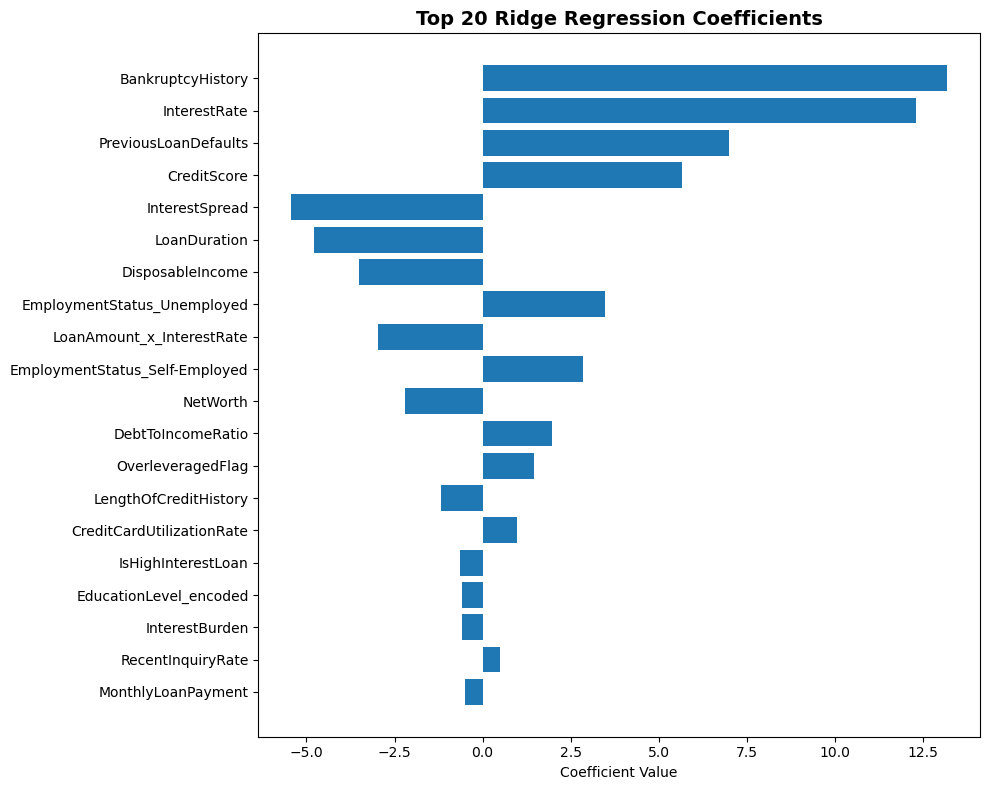

In [5]:
print("Training Ridge Regression...")

# Extensive hyperparameter grid
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

ridge = Ridge(random_state=R_seed, max_iter=10000)
ridge_grid = GridSearchCV(
    ridge, 
    ridge_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

ridge_grid.fit(X_train_linear, y_train_linear)

print(f"\nBest parameters: {ridge_grid.best_params_}")
print(f"Best CV RMSE: {-ridge_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
ridge_cv = ridge_grid.best_estimator_
ridge_cv_metrics = evaluate_model(
    ridge_cv, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'Ridge (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
ridge_best = Ridge(**ridge_grid.best_params_, random_state=R_seed, max_iter=10000)
ridge_best.fit(X_train_linear, y_train_linear)

# Evaluate full retrained model
ridge_metrics = evaluate_model(
    ridge_best, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'Ridge Regression'

)

all_results.append(ridge_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/ridge_best.pkl', 'wb') as f:
    pickle.dump(ridge_best, f)
with open('../models/ridge_gridsearch.pkl', 'wb') as f:
    pickle.dump(ridge_grid, f)
print("✓ Ridge model saved")

# Feature importance (coefficients)
feature_names = data_linear['feature_names'] if 'feature_names' in data_linear else [f'Feature_{i}' for i in range(X_train_linear.shape[1])]

ridge_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_best.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(ridge_coef['Feature'], ridge_coef['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Ridge Regression Coefficients', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---
# Model 2: Lasso Regression

Training Lasso Regression...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters: {'alpha': 0.001, 'selection': 'cyclic'}
Best CV RMSE: 3.4541

--- Evaluation with GridSearchCV best_estimator (CV-trained) ---

Lasso (CV) - Performance Metrics
Training Set:
  RMSE: 3.4337
  MAE:  2.6903
  R²:   0.8037

Test Set:
  RMSE: 3.6487
  MAE:  2.8083
  R²:   0.7856

--- Retraining on full training data ---

Lasso Regression - Performance Metrics
Training Set:
  RMSE: 3.4337
  MAE:  2.6903
  R²:   0.8037

Test Set:
  RMSE: 3.6487
  MAE:  2.8083
  R²:   0.7856
✓ Lasso model saved

Lasso selected 55 features out of 57


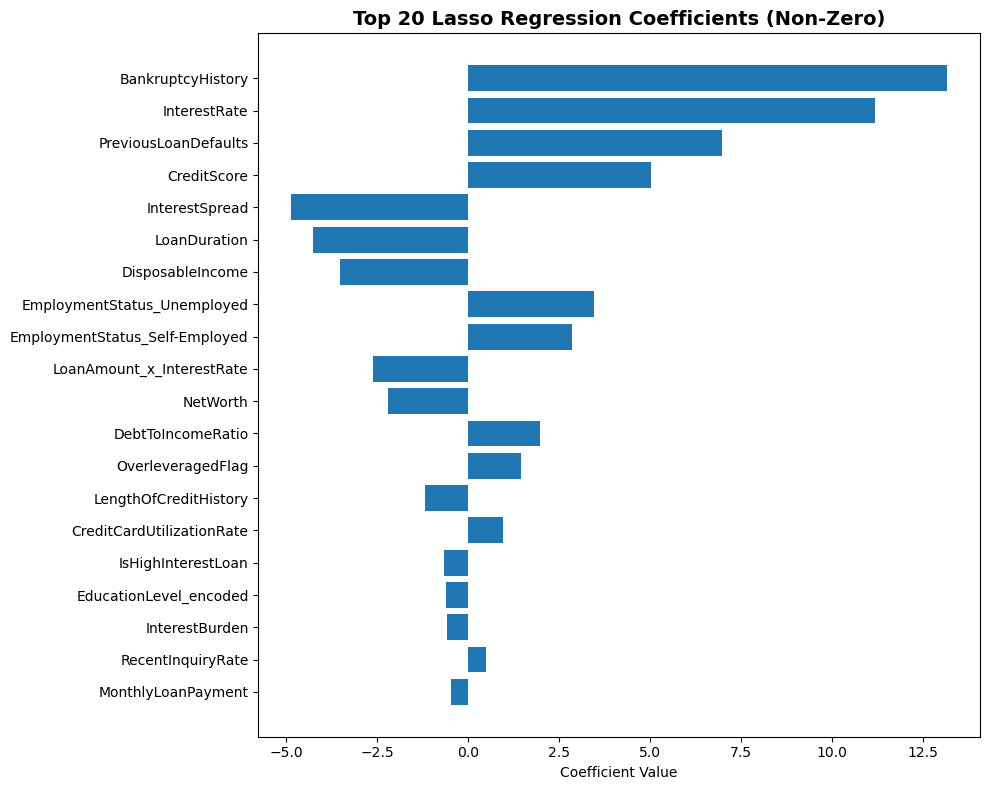

In [6]:
print("Training Lasso Regression...")

# Extensive hyperparameter grid
lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
    'selection': ['cyclic', 'random']
}

lasso = Lasso(random_state=R_seed, max_iter=10000)
lasso_grid = GridSearchCV(
    lasso, 
    lasso_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

lasso_grid.fit(X_train_linear, y_train_linear)

print(f"\nBest parameters: {lasso_grid.best_params_}")
print(f"Best CV RMSE: {-lasso_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
lasso_cv = lasso_grid.best_estimator_
lasso_cv_metrics = evaluate_model(
    lasso_cv, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'Lasso (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
lasso_best = Lasso(**lasso_grid.best_params_, random_state=R_seed, max_iter=10000)
lasso_best.fit(X_train_linear, y_train_linear)

# Evaluate full retrained model
lasso_metrics = evaluate_model(
    lasso_best, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'Lasso Regression'

)
all_results.append(lasso_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/lasso_best.pkl', 'wb') as f:
    pickle.dump(lasso_best, f)
with open('../models/lasso_gridsearch.pkl', 'wb') as f:
    pickle.dump(lasso_grid, f)
print("✓ Lasso model saved")

# Feature importance (coefficients)
feature_names = data_linear['feature_names'] if 'feature_names' in data_linear else [f'Feature_{i}' for i in range(X_train_linear.shape[1])]

lasso_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_best.coef_
})
selected_features = lasso_coef[lasso_coef['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False).head(20)
print(f"\nLasso selected {len(lasso_coef[lasso_coef['Coefficient'] != 0])} features out of {len(lasso_coef)}")

plt.figure(figsize=(10, 8))
plt.barh(selected_features['Feature'], selected_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Lasso Regression Coefficients (Non-Zero)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
# Model 3: ElasticNet

Training ElasticNet...
Fitting 5 folds for each of 112 candidates, totalling 560 fits

Best parameters: {'alpha': 0.001, 'l1_ratio': 0.99, 'selection': 'cyclic'}
Best CV RMSE: 3.4542

--- Evaluation with GridSearchCV best_estimator (CV-trained) ---

ElasticNet (CV) - Performance Metrics
Training Set:
  RMSE: 3.4338
  MAE:  2.6903
  R²:   0.8037

Test Set:
  RMSE: 3.6486
  MAE:  2.8082
  R²:   0.7856

--- Retraining on full training data ---

ElasticNet - Performance Metrics
Training Set:
  RMSE: 3.4338
  MAE:  2.6903
  R²:   0.8037

Test Set:
  RMSE: 3.6486
  MAE:  2.8082
  R²:   0.7856
✓ ElasticNet model saved

ElasticNet selected 55 features out of 57


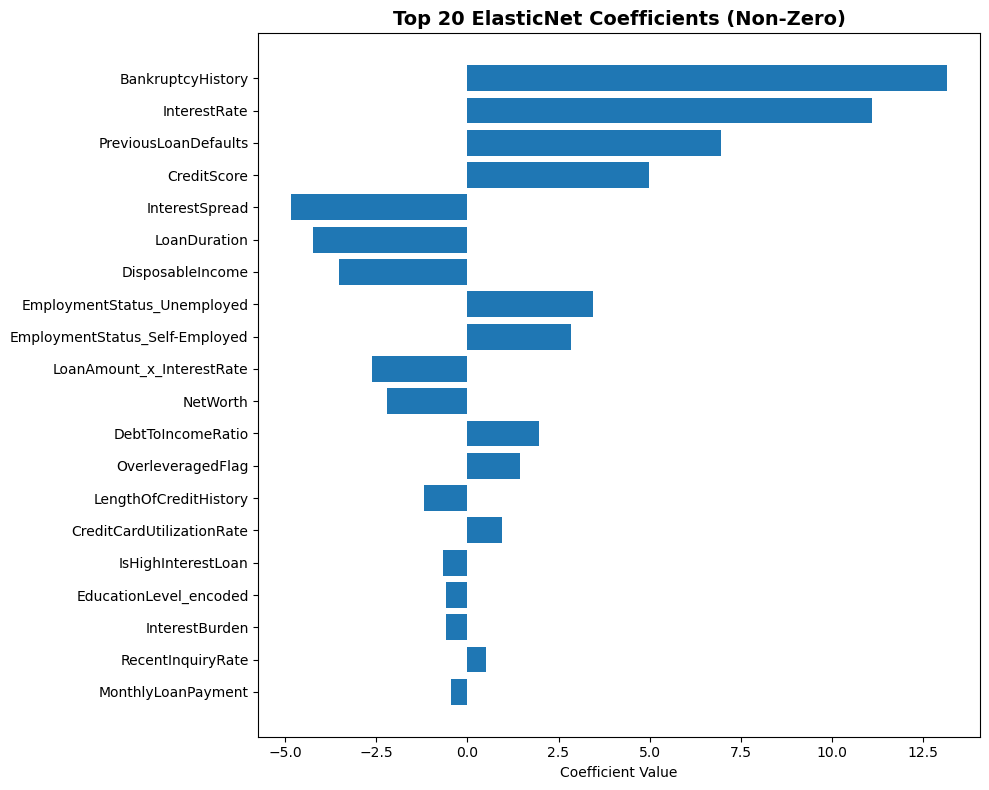

In [7]:
print("Training ElasticNet...")

# Extensive hyperparameter grid
elasticnet_params = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99],
    'selection': ['cyclic', 'random']
}

elasticnet = ElasticNet(random_state=R_seed, max_iter=10000)
elasticnet_grid = GridSearchCV(
    elasticnet, 
    elasticnet_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

elasticnet_grid.fit(X_train_linear, y_train_linear)

print(f"\nBest parameters: {elasticnet_grid.best_params_}")
print(f"Best CV RMSE: {-elasticnet_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
elasticnet_cv = elasticnet_grid.best_estimator_
elasticnet_cv_metrics = evaluate_model(
    elasticnet_cv, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'ElasticNet (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
elasticnet_best = ElasticNet(**elasticnet_grid.best_params_, random_state=R_seed, max_iter=10000)
elasticnet_best.fit(X_train_linear, y_train_linear)

# Evaluate full retrained model
elasticnet_metrics = evaluate_model(
    elasticnet_best, 
    X_train_linear, y_train_linear, 
    X_test_linear, y_test_linear,
    'ElasticNet'

)
all_results.append(elasticnet_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/elasticnet_best.pkl', 'wb') as f:
    pickle.dump(elasticnet_best, f)
with open('../models/elasticnet_gridsearch.pkl', 'wb') as f:
    pickle.dump(elasticnet_grid, f)
print("✓ ElasticNet model saved")

# Feature importance (coefficients)
feature_names = data_linear['feature_names'] if 'feature_names' in data_linear else [f'Feature_{i}' for i in range(X_train_linear.shape[1])]

elasticnet_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': elasticnet_best.coef_
})
selected_features = elasticnet_coef[elasticnet_coef['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False).head(20)
print(f"\nElasticNet selected {len(elasticnet_coef[elasticnet_coef['Coefficient'] != 0])} features out of {len(elasticnet_coef)}")

plt.figure(figsize=(10, 8))
plt.barh(selected_features['Feature'], selected_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 ElasticNet Coefficients (Non-Zero)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
# Model 4: Random Forest

In [ ]:
print("Training Random Forest Regressor...")
# Smaller hyperparameter grid centered around previously found best params
rf_params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [False]
}

rf = RandomForestRegressor(random_state=R_seed, n_jobs=-1)
rf_grid = GridSearchCV(
    rf, 
    rf_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train_tree, y_train_tree)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV RMSE: {-rf_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
rf_cv = rf_grid.best_estimator_
rf_cv_metrics = evaluate_model(
    rf_cv, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'Random Forest (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
rf_best = RandomForestRegressor(**rf_grid.best_params_, random_state=R_seed, n_jobs=-1)
rf_best.fit(X_train_tree, y_train_tree)

# Evaluate full retrained model
rf_metrics = evaluate_model(
    rf_best, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'Random Forest'

)
all_results.append(rf_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/random_forest_best.pkl', 'wb') as f:
    pickle.dump(rf_best, f)
with open('../models/random_forest_gridsearch.pkl', 'wb') as f:
    pickle.dump(rf_grid, f)
print("✓ Random Forest model saved")

# Feature importance
feature_names = data_tree['feature_names'] if 'feature_names' in data_tree else [f'Feature_{i}' for i in range(X_train_tree.shape[1])]

rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(rf_importance['Feature'], rf_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Random Forest Feature Importance', fontsize=14, fontweight='bold')

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

---
# Model 5: XGBoost

In [ ]:
print("Training XGBoost Regressor...")

# Smaller hyperparameter grid centered around previously found best params
xgb_params = {
    'n_estimators': [400, 500, 600],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'min_child_weight': [4, 5, 6],
    'gamma': [0.1, 0.2]
}

xgb_model = xgb.XGBRegressor(
    random_state=R_seed,
    n_jobs=-1,
    tree_method='hist'
)

xgb_grid = GridSearchCV(
    xgb_model, 
    xgb_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

xgb_grid.fit(X_train_tree, y_train_tree)

print(f"\nBest parameters: {xgb_grid.best_params_}")
print(f"Best CV RMSE: {-xgb_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
xgb_cv = xgb_grid.best_estimator_
xgb_cv_metrics = evaluate_model(
    xgb_cv, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'XGBoost (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
xgb_best = xgb.XGBRegressor(**xgb_grid.best_params_, random_state=R_seed, n_jobs=-1, tree_method='hist')
xgb_best.fit(X_train_tree, y_train_tree)

# Evaluate full retrained model
xgb_metrics = evaluate_model(
    xgb_best, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'XGBoost'

)
all_results.append(xgb_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/xgboost_best.pkl', 'wb') as f:
    pickle.dump(xgb_best, f)
with open('../models/xgboost_gridsearch.pkl', 'wb') as f:
    pickle.dump(xgb_grid, f)
print("✓ XGBoost model saved")

# Feature importance
feature_names = data_tree['feature_names'] if 'feature_names' in data_tree else [f'Feature_{i}' for i in range(X_train_tree.shape[1])]

xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(xgb_importance['Feature'], xgb_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 XGBoost Feature Importance', fontsize=14, fontweight='bold')

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

---
# Model 6: LightGBM

In [ ]:
print("Training LightGBM Regressor...")

# Reduced hyperparameter grid for overnight completion
lgb_params = {
    'n_estimators': [300, 500],
    'max_depth': [7, -1],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 63],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_samples': [20],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.1]
}

lgb_model = lgb.LGBMRegressor(
    random_state=R_seed,
    n_jobs=-1,
    verbose=-1
)

lgb_grid = GridSearchCV(
    lgb_model, 
    lgb_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

lgb_grid.fit(X_train_tree, y_train_tree)

print(f"\nBest parameters: {lgb_grid.best_params_}")
print(f"Best CV RMSE: {-lgb_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
lgb_cv = lgb_grid.best_estimator_
lgb_cv_metrics = evaluate_model(
    lgb_cv, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'LightGBM (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
lgb_best = lgb.LGBMRegressor(**lgb_grid.best_params_, random_state=R_seed, n_jobs=-1, verbose=-1)
lgb_best.fit(X_train_tree, y_train_tree)

# Evaluate full retrained model
lgb_metrics = evaluate_model(
    lgb_best, 
    X_train_tree, y_train_tree, 
    X_test_tree, y_test_tree,
    'LightGBM'

)
all_results.append(lgb_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/lightgbm_best.pkl', 'wb') as f:
    pickle.dump(lgb_best, f)
with open('../models/lightgbm_gridsearch.pkl', 'wb') as f:
    pickle.dump(lgb_grid, f)
print("✓ LightGBM model saved")

# Feature importance
feature_names = data_tree['feature_names'] if 'feature_names' in data_tree else [f'Feature_{i}' for i in range(X_train_tree.shape[1])]

lgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgb_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(lgb_importance['Feature'], lgb_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 LightGBM Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---
# Model 7: CatBoost

In [ ]:
print("Training CatBoost Regressor...")

# Reduced hyperparameter grid for overnight completion
catboost_params = {
    'iterations': [300, 500],
    'depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [3],
    'border_count': [128],
    'bagging_temperature': [0.5],
    'random_strength': [1]
}

catboost_model = CatBoostRegressor(
    random_state=R_seed,
    verbose=0,
    thread_count=-1,
    cat_features=cat_features_idx
)

catboost_grid = GridSearchCV(
    catboost_model, 
    catboost_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=1,  # CatBoost handles parallelization internally
    verbose=2
)

catboost_grid.fit(X_train_catboost, y_train_catboost)

print(f"\nBest parameters: {catboost_grid.best_params_}")
print(f"Best CV RMSE: {-catboost_grid.best_score_:.4f}")

# Evaluate GridSearchCV best estimator (trained on CV folds)
print("\n--- Evaluation with GridSearchCV best_estimator (CV-trained) ---")
catboost_cv = catboost_grid.best_estimator_
catboost_cv_metrics = evaluate_model(
    catboost_cv, 
    X_train_catboost, y_train_catboost, 
    X_test_catboost, y_test_catboost,
    'CatBoost (CV)'
)

# Retrain on full training data with best hyperparameters
print("\n--- Retraining on full training data ---")
catboost_best = CatBoostRegressor(**catboost_grid.best_params_, random_state=R_seed, verbose=0, thread_count=-1, cat_features=cat_features_idx)
catboost_best.fit(X_train_catboost, y_train_catboost)

# Evaluate full retrained model
catboost_metrics = evaluate_model(
    catboost_best, 
    X_train_catboost, y_train_catboost, 
    X_test_catboost, y_test_catboost,
    'CatBoost'

)
all_results.append(catboost_metrics)

# Save model immediately
os.makedirs('../models', exist_ok=True)
with open('../models/catboost_best.pkl', 'wb') as f:
    pickle.dump(catboost_best, f)
with open('../models/catboost_gridsearch.pkl', 'wb') as f:
    pickle.dump(catboost_grid, f)
print("✓ CatBoost model saved")

# Feature importance
feature_names = data_catboost['feature_names'] if 'feature_names' in data_catboost else [f'Feature_{i}' for i in range(X_train_catboost.shape[1])]

catboost_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': catboost_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(catboost_importance['Feature'], catboost_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 CatBoost Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


___
## Model 8: Convolutional Neural Network (CNN)

In [ ]:
# 2 setup

# Build CNN architecture function
def build_cnn_model(input_dim, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    """
    Build 1D CNN model for regression
    """
    input_shape = (input_dim, 1)
    model = models.Sequential([
        layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        
        layers.Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        
        layers.GlobalMaxPooling1D(),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create KerasRegressor wrapper for GridSearchCV
def create_cnn_model(filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    return build_cnn_model(
        input_dim=X_train_tree.shape[1],
        filters=filters,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

# Wrap model for sklearn compatibility
cnn_model = KerasRegressor(
    model=create_cnn_model,
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[
        callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-7)
    ]
)

print("CNN model wrapper created successfully!")
print(f"Input features: {X_train_tree.shape[1]}")

In [ ]:
# 3 define grid search parameters
cnn_params = {
    'model__filters': [32, 64],
    'model__kernel_size': [2, 3],
    'model__dropout_rate': [0.2, 0.3],
    'model__learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64]
}

print(f"CNN Parameter Grid:")
for param, values in cnn_params.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in cnn_params.values()])
print(f"\nTotal combinations: {total_combinations}")
print(f"With {N_FOLDS}-fold CV: {total_combinations * N_FOLDS} model fits")

# Create custom scoring for GridSearchCV (negative MSE)
from sklearn.metrics import make_scorer
def custom_scorer(y_true, y_pred):
    # Reshape data for CNN if needed
    if hasattr(y_pred, 'shape') and len(y_pred.shape) > 1:
        y_pred = y_pred.flatten()
    return -mean_squared_error(y_true, y_pred)

# Perform GridSearchCV
print("\nStarting CNN GridSearchCV...")
cnn_grid = GridSearchCV(
    estimator=cnn_model,
    param_grid=cnn_params,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=1,  # CNN training is already parallelized internally
    verbose=2,
    error_score='raise'
)

# Reshape data for CNN
X_train_cnn = X_train_tree.reshape(X_train_tree.shape[0], X_train_tree.shape[1], 1)
X_test_cnn = X_test_tree.reshape(X_test_tree.shape[0], X_test_tree.shape[1], 1)

# Fit grid search
cnn_grid.fit(X_train_cnn, y_train_tree)

print("\n" + "="*80)
print("CNN GridSearchCV Results:")
print("="*80)
print(f"Best parameters: {cnn_grid.best_params_}")
print(f"Best CV RMSE: {np.sqrt(-cnn_grid.best_score_):.4f}")
print(f"Best CV MSE: {-cnn_grid.best_score_:.4f}")

In [ ]:
# 4 evaluation of cv-trained model
print("\nEvaluating CNN model trained with cross-validation...")

# Create wrapper for evaluation
class CNNWrapper:
    def __init__(self, model):
        self.model = model
    
    def predict(self, X):
        # Reshape if needed
        if len(X.shape) == 2:
            X = X.reshape(X.shape[0], X.shape[1], 1)
        predictions = self.model.predict(X, verbose=0)
        # Flatten predictions
        if hasattr(predictions, 'flatten'):
            return predictions.flatten()
        return predictions

cnn_cv_wrapper = CNNWrapper(cnn_grid.best_estimator_)

# Evaluate CV-trained model
cnn_cv_metrics = evaluate_model(
    cnn_cv_wrapper,
    X_train_tree, y_train_tree,
    X_test_tree, y_test_tree,
    '1D CNN (CV)'
)

print("\n" + "="*80)
print("CNN Model Performance (CV-trained):")
print("="*80)
for metric, value in cnn_cv_metrics.items():
    print(f"{metric}: {value}")

In [ ]:
# 5 training of full dataset
print("\n" + "="*80)
print("Training CNN on Full Training Dataset")
print("="*80)

# Get best parameters
best_params = cnn_grid.best_params_
print(f"Using best parameters: {best_params}")

# Build final model with best parameters
cnn_best = build_cnn_model(
    input_dim=X_train_tree.shape[1],
    filters=best_params.get('model__filters', 64),
    kernel_size=best_params.get('model__kernel_size', 3),
    dropout_rate=best_params.get('model__dropout_rate', 0.3),
    learning_rate=best_params.get('model__learning_rate', 0.001)
)

print("\nCNN Architecture:")
print("="*80)
cnn_best.summary()
print("="*80)

# Training callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Train on full training data
print("\nTraining on full training dataset...")
batch_size = best_params.get('batch_size', 32)

history = cnn_best.fit(
    X_train_cnn, y_train_tree,
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✓ CNN training on full dataset complete!")
print(f"Training stopped at epoch: {len(history.history['loss'])}")

In [ ]:
# 6 Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].set_title('CNN Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2, color='coral')
axes[1].set_title('CNN Training MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 7 Evaluate CNN trained on full dataset
print("\nEvaluating CNN model trained on full dataset...")

cnn_best_wrapper = CNNWrapper(cnn_best)

cnn_metrics = evaluate_model(
    cnn_best_wrapper,
    X_train_tree, y_train_tree,
    X_test_tree, y_test_tree,
    '1D CNN'
)

print("\n" + "="*80)
print("CNN Model Performance (Full Training):")
print("="*80)
for metric, value in cnn_metrics.items():
    print(f"{metric}: {value}")

# Compare CV vs Full Training
print("\n" + "="*80)
print("CV-trained vs Full-trained Comparison:")
print("="*80)
print(f"Test RMSE (CV):   {cnn_cv_metrics['Test RMSE']:.4f}")
print(f"Test RMSE (Full): {cnn_metrics['Test RMSE']:.4f}")
print(f"Improvement:      {cnn_cv_metrics['Test RMSE'] - cnn_metrics['Test RMSE']:.4f}")

# Add to results
all_results.append(cnn_metrics)

In [ ]:
# 8 saving CNN model and results
print("\nSaving CNN model...")

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the trained model
cnn_best.save('../models/cnn_model.h5')
print("✓ CNN model saved to: ../models/cnn_model.h5")

# Save grid search results
with open('../models/cnn_gridsearch.pkl', 'wb') as f:
    pickle.dump({
        'grid_search': cnn_grid,
        'best_params': cnn_grid.best_params_,
        'best_score': cnn_grid.best_score_,
        'cv_results': cnn_grid.cv_results_
    }, f)
print("✓ CNN grid search saved to: ../models/cnn_gridsearch.pkl")

# Save training history
with open('../models/cnn_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✓ CNN training history saved to: ../models/cnn_history.pkl")

print("\n" + "="*80)

In [ ]:
# 9 CNN Feature Importance using Permutation Importance
print("\nCalculating CNN Feature Importance...")
print("(Using permutation importance - this may take a moment)")

from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    cnn_best_wrapper,
    X_test_tree,
    y_test_tree,
    n_repeats=10,
    random_state=R_seed,
    n_jobs=-1
)

# Create importance dataframe
feature_names = data_tree['feature_names'] if 'feature_names' in data_tree else [f'Feature_{i}' for i in range(X_train_tree.shape[1])]

cnn_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False).head(20)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cnn_importance['Feature'], cnn_importance['Importance'])
plt.xlabel('Permutation Importance')
plt.title('Top 20 CNN Feature Importance (Permutation)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✓ CNN feature importance analysis complete!")

---
## Model Comparison

In [ ]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame(all_results)

print("\n" + "="*120)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test RMSE
axes[0, 0].barh(results_df['Model'], results_df['Test_RMSE'])
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Test Set RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()

# Test MAE
axes[0, 1].barh(results_df['Model'], results_df['Test_MAE'])
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_title('Test Set MAE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

# Test R²
axes[1, 0].barh(results_df['Model'], results_df['Test_R2'])
axes[1, 0].set_xlabel('R² Score')
axes[1, 0].set_title('Test Set R² Comparison', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()

# All metrics comparison
x = np.arange(len(results_df))
width = 0.35
axes[1, 1].bar(x - width/2, results_df['Train_R2'], width, label='Train R²', alpha=0.8)
axes[1, 1].bar(x + width/2, results_df['Test_R2'], width, label='Test R²', alpha=0.8)
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('R² Scores Across Train and Test Sets', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()